In [94]:
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings('ignore')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [63]:
SEED = 42

In [64]:
list_businesses = [line.strip() for line in open("list_of_businesses.txt", 'r')]
list_hs_codes = [line.strip() for line in open("list_hs_codes.txt", 'r')]
list_strengthes = [line.strip() for line in open("list_strengthes.txt", 'r')]

In [65]:
def prepare_data(path, status, threshold=None):
    """
    path, str to dataset, e.g 'model_passed_review.csv'
    status, could be 'passed' or 'failed'
    threshold - limit the number of rows in dataset
    e.g. prepare_data('model_passed_review.csv', 'passed')
    """
    df = pd.read_csv(path, header = None)
    
    df = df.drop([4, 5], axis=1)
    df = df.rename(columns=
                       {0 : "Business", 
                        1 : "Part_number",
                        2 : "Part_description",
                        3 : "HS_code",
                        6 : "Audit_trail",
                        7 : "Strength"})
    df = df.drop_duplicates(subset=['Audit_trail', 'HS_code']).reset_index(drop=True)
    #threshold
    if threshold != None:
        df = df.sample(random_state=SEED, frac=1).reset_index(drop=True)
        df = df[:threshold]

    df = df.fillna('missed_data')
    df['HS_code'] = df['HS_code'].astype('str')
    df['Strength'] = df['Strength'].astype('str')
    #converting the missing strengthes
    df['Business'] = df['Business'].apply(lambda x: x if x in list_businesses else 'unknown')
    df['HS_code'] = df['HS_code'].apply(lambda x: x if x in list_hs_codes else 'unknown')
    df['Strength'] = df['Strength'].apply(lambda x: x if x in list_strengthes else 'unknown')
    #adding the label
    if status == "passed":
        df['Failed'] = 0
    else:
        df['Failed'] = 1
    df_text = df['Part_description'] + "  " + df['Audit_trail']
    df_partnumber = df['Part_number']
    df_features = df[['Business', 'HS_code', 'Strength']]
    y = df['Failed']

    return df_text, df_partnumber, df_features, y

In [66]:
passed_text, passed_partnumber, passed_features, y_passed = prepare_data('model_passed_review.csv', 'passed', threshold=40000)
failed_text, failed_partnumber, failed_features, y_failed = prepare_data('model_failed_review.csv', 'failed', threshold=40000)

In [67]:
df_train_text = pd.concat([passed_text, failed_text], ignore_index=True)
df_train_partnumber = pd.concat([passed_partnumber, failed_partnumber], ignore_index=True)
df_train_features = pd.concat([passed_features, failed_features], ignore_index=True)
y = pd.concat([y_passed, y_failed], ignore_index=True)

In [68]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

cachedStopWords = stopwords.words("english")

# def remove_stopwords(text):
#     text = ' '.join([word for word in text.split() if word not in cachedStopWords])
#     return text

stemmer = SnowballStemmer('english')
#stemmer = PorterStemmer()
#lemmatizer = WordNetLemmatizer()

In [69]:
#The function takes as input dataset and columns to process
def clean_data(df):
    df = df.apply(lambda x : remove_URL(x))
    df = df.apply(lambda x : remove_punct(x))
    # df = df.apply(lambda x : remove_stopwords(x))
    df = df.apply(lambda x : stemmer.stem(x))
    # df = df.apply(lambda x : lemmatizer.lemmatize(x))

    return df

In [70]:
df_cleaned_train_text = clean_data(df_train_text)
# print('text reducing is ', len(" ".join(df_cleaned_train_text))/len(" ".join(df_train_text)))

In [71]:
df_cleaned_train_text[8653]

'push button switchdescentascent  per attached engineer response this is a push button switch it is rated for 230 v and 4 a it is not electromechanical snap on switch not for use in aircraft'

In [72]:
MAX_DF = 0.8
MIN_COUNT = 5
NGRAMS = (1, 2)
MAX_FEATURES = 100000

In [73]:
tfidf_text_vectorizer = TfidfVectorizer(max_df=MAX_DF, 
                                        min_df=MIN_COUNT, 
                                        ngram_range=NGRAMS, 
                                        max_features=MAX_FEATURES,
                                        stop_words = stopwords.words("english"))
df_cleaned_train_text_sparse = tfidf_text_vectorizer.fit_transform(df_cleaned_train_text)
df_cleaned_train_text_sparse

<80000x81230 sparse matrix of type '<class 'numpy.float64'>'
	with 3061233 stored elements in Compressed Sparse Row format>

In [74]:
tfidf_partnumber_vectorizer = TfidfVectorizer(analyzer='char')
df_train_partnumber_sparse = tfidf_partnumber_vectorizer.fit_transform(df_train_partnumber)

In [75]:
df_train_partnumber_sparse

<80000x65 sparse matrix of type '<class 'numpy.float64'>'
	with 624674 stored elements in Compressed Sparse Row format>

In [76]:
enc = OneHotEncoder(categories=(list_businesses, list_hs_codes, list_strengthes))

In [77]:
df_train_features_sparse = enc.fit_transform(df_train_features)
df_train_features_sparse

<80000x1365 sparse matrix of type '<class 'numpy.float64'>'
	with 240000 stored elements in Compressed Sparse Row format>

In [78]:
df_total = hstack([df_cleaned_train_text_sparse, df_train_partnumber_sparse, df_train_features_sparse])
df_total.shape[1] == len(tfidf_text_vectorizer.vocabulary_) + \
                    len(tfidf_partnumber_vectorizer.vocabulary_) + \
                    len(list_businesses) + len(list_hs_codes) + len(list_strengthes)

True

In [79]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df_total, y, 
                                                          test_size=0.3, 
                                                          random_state=SEED)

In [80]:
clf = LogisticRegression(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % accuracy_score(y_train, clf.predict(X_train)))
print('F1 score (holdout) %.3f' % accuracy_score(y_holdout, clf.predict(X_holdout)))

F1 score (train) 0.797
F1 score (holdout) 0.709


In [81]:
clf2 = RidgeClassifier(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf2.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf2.predict(X_holdout)))

F1 score (train) 0.894
F1 score (holdout) 0.716


In [82]:
clf3 = MultinomialNB().fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf3.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf3.predict(X_holdout)))

F1 score (train) 0.739
F1 score (holdout) 0.677


In [83]:
clf4 = svm.LinearSVC(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf4.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf4.predict(X_holdout)))

F1 score (train) 0.925
F1 score (holdout) 0.710


In [84]:
test_passed_text, test_passed_partnumber, test_passed_features, y_passed_test = prepare_data('test_passed_review.csv', 
                                                                                            'passed', threshold=20000)
test_failed_text, test_failed_partnumber, test_failed_features, y_failed_test = prepare_data('test_failed_review.csv', 
                                                                                                'failed', threshold=20000)

In [85]:
df_test_text = pd.concat([test_passed_text, test_failed_text], ignore_index=True)
df_test_partnumber = pd.concat([test_passed_partnumber, test_failed_partnumber], ignore_index=True)
df_test_features = pd.concat([test_passed_features, test_failed_features], ignore_index=True)
y_test = pd.concat([y_passed_test, y_failed_test], ignore_index=True)

In [86]:
def test_the_model(df_text, df_partnumber, df_features, encoders):
    
    df_cleaned_text = clean_data(df_text)
    df_text_sparse = encoders[0].transform(df_cleaned_text)
    df_partnumber_sparse = encoders[1].transform(df_partnumber)
    df_features_sparse = encoders[2].transform(df_features)
    df_out = hstack([df_text_sparse, df_partnumber_sparse, df_features_sparse])

    return df_out

In [87]:
X_test = test_the_model(df_test_text, 
                        df_test_partnumber, 
                        df_test_features, 
                        encoders = [tfidf_text_vectorizer, tfidf_partnumber_vectorizer, enc])

In [88]:
print('Logistic regression F1 score (test) %.3f' % f1_score(y_test, clf.predict(X_test)))
print('Ridge Clasifier F1 score (test) %.3f' % f1_score(y_test, clf2.predict(X_test)))
print('Naive Bayes F1 score (test) %.3f' % f1_score(y_test, clf3.predict(X_test)))
print('Linear SVM F1 score (test) %.3f' % f1_score(y_test, clf4.predict(X_test)))

Logistic regression F1 score (test) 0.687
Ridge Clasifier F1 score (test) 0.677
Naive Bayes F1 score (test) 0.673
Linear SVM F1 score (test) 0.669


In [89]:
preds = pd.DataFrame(clf.predict_proba(X_test), columns = ['Prob_of_0', 'Prob_of_1'])

In [90]:
preds['AT'] = df_test_text
preds[['Business', 'HS_code', 'Strength']] = df_test_features
preds['True'] = y_test

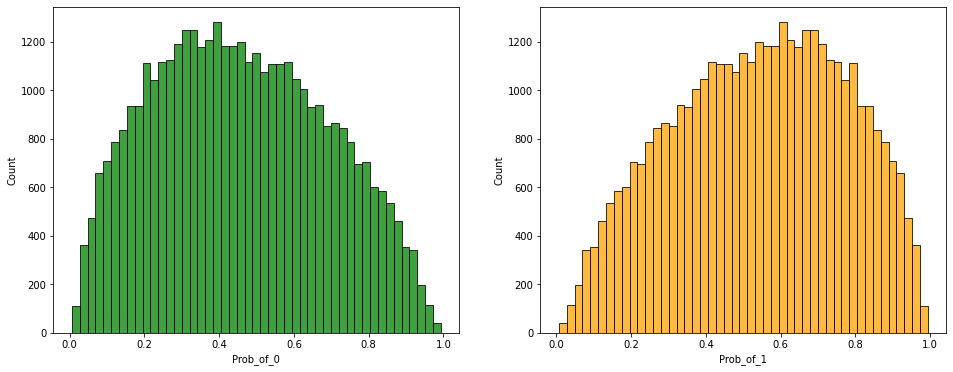

In [91]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(preds['Prob_of_0'], color='green', ax=axs[0])
sns.histplot(preds['Prob_of_1'], color='orange', ax=axs[1]);


In [92]:
# only passed
df_test_text = test_passed_text
df_test_partnumber = test_passed_partnumber
df_test_features = test_passed_features
y_test = y_passed_test
X_test = test_the_model(df_test_text, 
                        df_test_partnumber, 
                        df_test_features, 
                        encoders = [tfidf_text_vectorizer, tfidf_partnumber_vectorizer, enc])
print('Logistic regression accuracy score (test) %.3f' % accuracy_score(y_test, clf.predict(X_test)))
print('Ridge Clasifier accuracy score (test) %.3f' % accuracy_score(y_test, clf2.predict(X_test)))
print('Naive Bayes accuracy score (test) %.3f' % accuracy_score(y_test, clf3.predict(X_test)))
print('Linear SVM accuracy score (test) %.3f' % accuracy_score(y_test, clf4.predict(X_test)))

Logistic regression accuracy score (test) 0.588
Ridge Clasifier accuracy score (test) 0.602
Naive Bayes accuracy score (test) 0.604
Linear SVM accuracy score (test) 0.602


In [93]:
# only failed
df_test_text = test_failed_text
df_test_partnumber = test_failed_partnumber
df_test_features = test_failed_features
y_test = y_failed_test
X_test = test_the_model(df_test_text, 
                        df_test_partnumber, 
                        df_test_features, 
                        encoders = [tfidf_text_vectorizer, tfidf_partnumber_vectorizer, enc])
print('Logistic regression accuracy score (test) %.3f' % accuracy_score(y_test, clf.predict(X_test)))
print('Ridge Clasifier accuracy score (test) %.3f' % accuracy_score(y_test, clf2.predict(X_test)))
print('Naive Bayes accuracy score (test) %.3f' % accuracy_score(y_test, clf3.predict(X_test)))
print('Linear SVM accuracy score (test) %.3f' % accuracy_score(y_test, clf4.predict(X_test)))

Logistic regression accuracy score (test) 0.742
Ridge Clasifier accuracy score (test) 0.719
Naive Bayes accuracy score (test) 0.710
Linear SVM accuracy score (test) 0.705


In [97]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(clf, filename)

['finalized_model.sav']

In [ ]:
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)